# Prepare the data

In [91]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [92]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

In [93]:
X, y = mnist["data"], mnist["target"]
X.shape
X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000], y[50000:]
shuffle_index = np.random.permutation(50000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# The data is prepared

1 Estimate MNIST SGDClassifier to distinguish digit 3 from other digits. Report average precision rate when the recall = 86.1% (you can round up the recall value up to the 3rd digit). Use cv = 3. Draw first 50,000 observations for training dataset and shuffle the data. Use random_state = 42.

In [94]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [95]:
# The alhorithm relies on randomness and for reproducibility requires random_state parameter.
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [96]:
some_digit = X[36000]

In [7]:
sgd_clf.predict([some_digit])

array([False])

In [97]:
# Let's start with accuracy
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.9647807 , 0.94882102, 0.90405616])

In [99]:
# Let's look at a simple binary classifier: correctly classify 5 vs. not-5 digits.
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    # We don't really fit anything
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # We return a vector of zeros effectively predicting that all digits are not-5
        return np.zeros((len(X), 1), dtype=bool)

In [100]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.87964241, 0.87946241, 0.87303492])

In [101]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

In [102]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_3, y_train_pred)

array([[41508,  2361],
       [  678,  5453]], dtype=int64)

In [103]:
y_train_perfect_predictions = y_train_3

In [104]:
# Example of perfect prediction. We made a table from two identical vectors. No errors!
confusion_matrix(y_train_3, y_train_perfect_predictions)

array([[43869,     0],
       [    0,  6131]], dtype=int64)

In [105]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_3, y_train_pred) 

0.6978500127975429

In [106]:
# Remember precision is TP / (TP + FP)
5453 / (5453 + 2361)

0.6978500127975429

In [107]:
recall_score(y_train_3, y_train_pred)

0.889414451149894

In [108]:
5453 / (5453 + 678)

0.889414451149894

In [109]:
from sklearn.metrics import f1_score
f1_score(y_train_3, y_train_pred)

0.7820724273933309

In [110]:
# Check the formula
5453 / (5453 + (678 + 5453)/2)

0.6401361742090743

In [111]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
# In this case the score is greteer than 0, so the digit is classified as 5.

array([-157781.06258449])

In [112]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [113]:
y_some_digit_pred

array([False])

In [114]:
threshold = 2000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [116]:
# Get the secision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3,
                             method="decision_function")

In [117]:
# Vector of decision score for the whole training datasets
y_scores.shape

(50000,)

In [118]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
# Use if you see the error.
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [119]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

Saving figure precision_recall_vs_threshold_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\precision_recall_vs_threshold_plot.png'

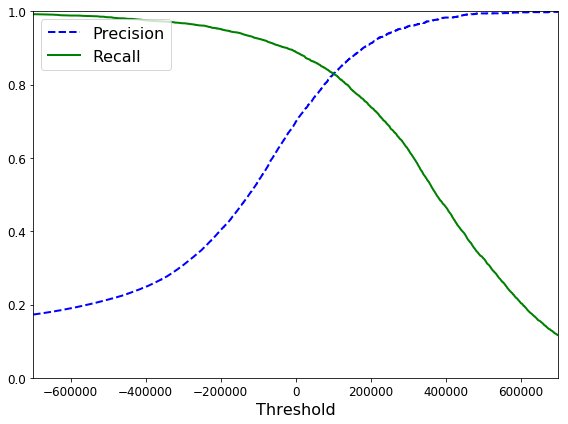

In [72]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [120]:
(y_train_pred == (y_scores > 0)).all()

True

In [121]:
y_train_pred_recall = (y_scores > 200000)

In [122]:
precision_score(y_train_3, y_train_pred_recall)

0.9126409017713365

In [123]:
recall_score(y_train_3, y_train_pred_recall)

0.7395204697439243

In [94]:
""" The precision rate is 91.2% when the recall rate is about 86.1% """

' The precision rate is 91.2% when the recall rate is about 86.1% '

# Problem 2 
Plot Precision-recall curve for the fit statistics from the problem 1 bounding precision between 70% and 95%.

Saving figure precision_vs_recall_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\precision_vs_recall_plot.png'

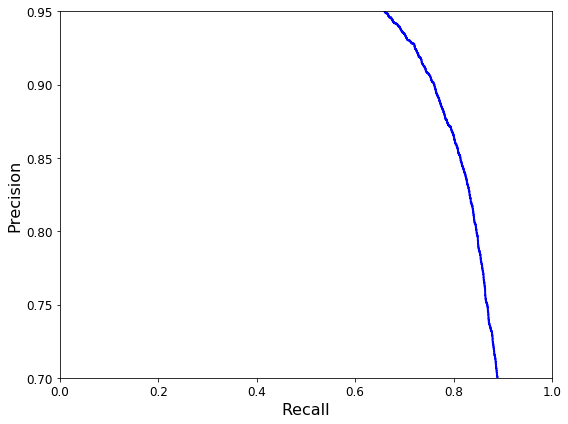

In [43]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, .70, .95])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# Problem 3 
What is the threshold that maximizes (precision + recall) from the previous problem? Report the threshold and maximum (precision + recall).

Saving figure precision_vs_recall_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\precision_vs_recall_plot.png'

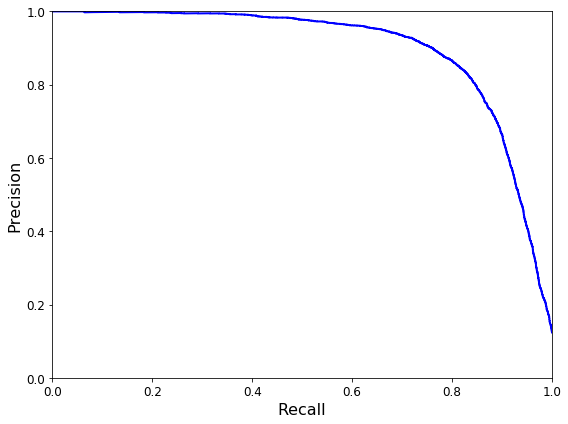

In [66]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Saving figure precision_vs_recall_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\precision_vs_recall_plot.png'

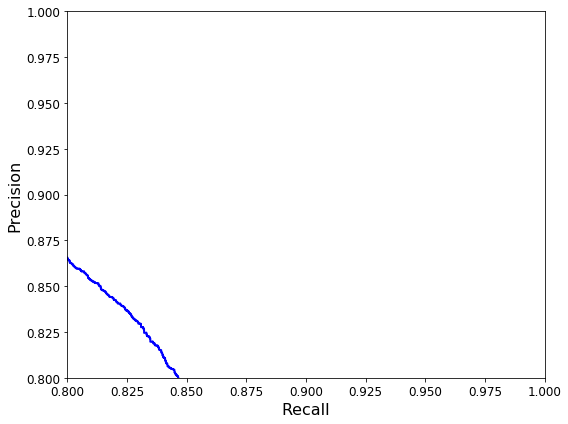

In [68]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([.8, 1, .8, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Saving figure precision_recall_vs_threshold_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\precision_recall_vs_threshold_plot.png'

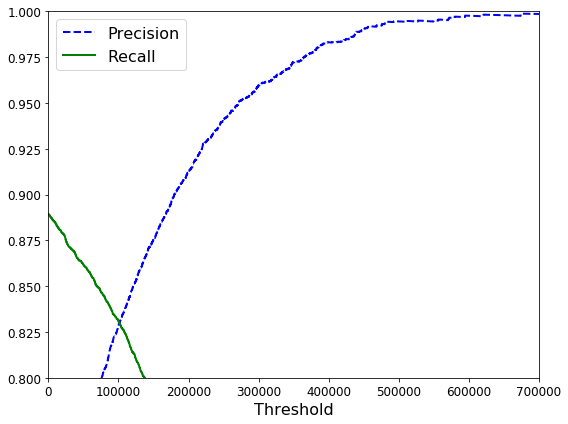

In [76]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([.8, 1])

plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

# Answer

In [ ]:
""" The threshold is about 100,000 the precision and recall values are about .83 """

# Titanic

In [1]:
import os

TITANIC_PATH = os.path.join("\\Users/ricfl/OneDrive/Desktop/ML/Homework_4")

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "train.csv")
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
Pclass: passenger class.
Name, Sex, Age: self-explanatory
SibSp: how many siblings & spouses of the passenger aboard the Titanic.
Parch: how many children & parents of the passenger aboard the Titanic.
Ticket: ticket id
Fare: price paid (in pounds)
Cabin: passenger's cabin number
Embarked: where the passenger embarked the Titanic

# Problem 4
Build a pipeline to impute missing data for ["Age", "SibSp", "Parch", "Fare"]. Also impute missing categorical variables ["Pclass", "Sex", "Embarked"] and convert them into indicator variables. Use median to impute the numerica variables and most common value to impute categorical variables. Merge the imputed variables with the rest of the data. Use "Survived" as a predictor and the rest of the variables as features. 

In [2]:
from sklearn.preprocessing import Imputer 
imputer = Imputer( strategy = "median")

In [3]:
train_num = train_data.drop(["Name", "Sex","Cabin","Ticket","Embarked","Pclass"], axis = 1)

In [4]:
train_num.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare
0,1,0,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,1,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,0,35.0,0,0,8.0500


In [5]:
imputer.fit(train_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [6]:
imputer.statistics_

array([446.    ,   0.    ,  28.    ,   0.    ,   0.    ,  14.4542])

In [7]:
train_num.median().values

array([446.    ,   0.    ,  28.    ,   0.    ,   0.    ,  14.4542])

In [8]:
train_cat = train_data.drop(["Age", "SibSp","Parch","Fare", "Name","Ticket","Cabin"], axis = 1)

train_cat.head(5)

,PassengerId,Survived,Pclass,Sex,Embarked
0,1,0,3,male,S
1,2,1,1,female,C
2,3,1,3,female,S
3,4,1,1,female,S
4,5,0,3,male,S


In [9]:
import numpy as np 
import pandas as pd 
from pandas.api.types import CategoricalDtype 

In [10]:
train_cat.groupby(['Embarked']).agg(['count'])

,PassengerId,Survived,Pclass,Sex
,count,count,count,count
Embarked,,,,
C,168,168,168,168
Q,77,77,77,77
S,644,644,644,644


In [11]:
train_cat['Embarked'].fillna('S', inplace=True)

In [12]:
train_cat['Embarked'].replace('', 'S', inplace=True)

In [13]:
train_cat.groupby(['Embarked']).agg(['count'])

,PassengerId,Survived,Pclass,Sex
,count,count,count,count
Embarked,,,,
C,168,168,168,168
Q,77,77,77,77
S,646,646,646,646


In [14]:
train_cat.groupby(['Sex']).agg(['count'])

,PassengerId,Survived,Pclass,Embarked
,count,count,count,count
Sex,,,,
female,314,314,314,314
male,577,577,577,577


In [15]:
train_cat['Sex'].fillna('male', inplace=True)

In [16]:
train_cat['Sex'].replace('', 'male', inplace=True)

In [17]:
train_cat.groupby(['Sex']).agg(['count'])

,PassengerId,Survived,Pclass,Embarked
,count,count,count,count
Sex,,,,
female,314,314,314,314
male,577,577,577,577


In [18]:
train_cat.groupby(['Pclass']).agg(['count'])

,PassengerId,Survived,Sex,Embarked
,count,count,count,count
Pclass,,,,
1,216,216,216,216
2,184,184,184,184
3,491,491,491,491


In [19]:
train_cat['Pclass'].fillna('3', inplace=True)

In [20]:
train_cat['Pclass'].replace('', '3', inplace=True)

In [21]:
train_cat.groupby(['Pclass']).agg(['count'])

,PassengerId,Survived,Sex,Embarked
,count,count,count,count
Pclass,,,,
1,216,216,216,216
2,184,184,184,184
3,491,491,491,491


In [22]:
new_train = train_num.merge(train_cat, how = 'inner', on = ('PassengerId', 'Survived'))

In [39]:
new_train.head(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,1,0,22.0,1,0,7.2500,3,male,S
1,2,1,38.0,1,0,71.2833,1,female,C
2,3,1,26.0,0,0,7.9250,3,female,S
3,4,1,35.0,1,0,53.1000,1,female,S
4,5,0,35.0,0,0,8.0500,3,male,S


In [24]:
train_label = new_train["Survived"].copy()
train_label.shape

(891,)

In [26]:
train_data = new_train.drop("Survived", axis = 1)
train_data.shape

(891, 8)

In [40]:
num_attribs = ["Age", "SibSp", "Fare", "Parch"]

In [41]:
cat_attribs = ["Pclass", "Sex", "Embarked"]

In [42]:
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [54]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
    ])

In [55]:
from sklearn.pipeline import FeatureUnion
# Run a pipeline for categorical and numerical features
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        #("cat_pipeline", cat_pipeline),
    ])

In [56]:
train_prepared = full_pipeline.fit_transform(train_data)
train_prepared

array([[-0.56573646,  0.43279337, -0.50244517, -0.47367361],
       [ 0.66386103,  0.43279337,  0.78684529, -0.47367361],
       [-0.25833709, -0.4745452 , -0.48885426, -0.47367361],
       ...,
       [-0.1046374 ,  0.43279337, -0.17626324,  2.00893337],
       [-0.25833709, -0.4745452 , -0.04438104, -0.47367361],
       [ 0.20276197, -0.4745452 , -0.49237783, -0.47367361]])

In [57]:
#Let’s first train a Linear Regression model, like we did in the previous chapter:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()


In [58]:
train_prepared.shape

(891, 4)

In [59]:
train_label.shape

(891,)

In [60]:
# Fit linear regression
lin_reg.fit(train_prepared, train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
from sklearn.metrics import mean_squared_error
lin_pred_state = lin_reg.predict(train_prepared)
lin_mse_state = mean_squared_error(train_label, lin_pred_state)
lin_rmse_state = np.sqrt(lin_mse_state)
lin_rmse_state

0.46453915334053403

# Problem 5
Estimate data predicting survival using KNN, RandomForestClassifier. Use cross-validation equal to four (cv=4). report ROC AUC score for each model. Set random_state = 42. In both methods use cross-validation with method="predict_proba", to make results comparable. 

In [99]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9669303530094951

In [96]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict_proba")

In [97]:
from scipy import stats
stats.describe(y_probas_forest)

DescribeResult(nobs=50000, minmax=(array([0., 0.]), array([1., 1.])), mean=array([0.877482, 0.122518]), variance=array([0.07142617, 0.07142617]), skewness=array([-2.3688991,  2.3688991]), kurtosis=array([4.28804628, 4.28804628]))

In [101]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
# Get fit data from the random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3,y_scores_forest)

Saving figure roc_curve_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\roc_curve_plot.png'

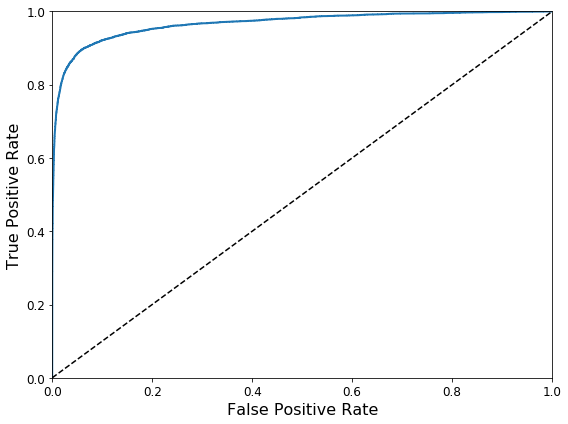

In [103]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

Saving figure roc_curve_comparison_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\roc_curve_comparison_plot.png'

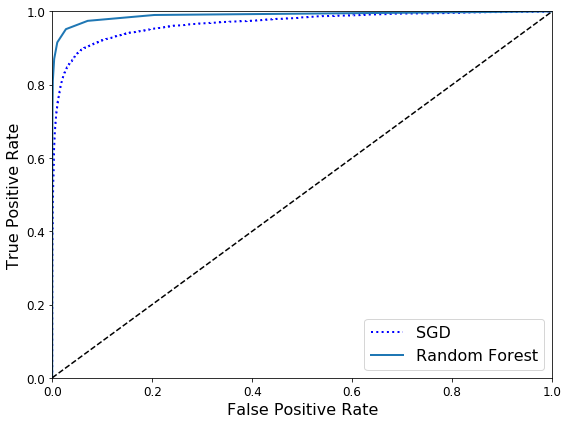

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [105]:
roc_auc_score(y_train_3, y_scores_forest)

0.9895044032785755

In [106]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)
precision_score(y_train_3, y_train_pred_forest)

0.9892494525184153

In [107]:
recall_score(y_train_3, y_train_pred_forest)

0.8104713749796119

# Problem 6
Repeat the same exerise as before, but instead of predicting probability of survival predict class, i.e., don't use  method="predict_proba". Instead of predicting probabilities you will be predicting the class with probability 1. Which method is better? How do you explain the difference between the results?

In [111]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict")

In [112]:
from scipy import stats
stats.describe(y_forest)

DescribeResult(nobs=50000, minmax=(False, True), mean=0.10046, variance=0.09036959579191581, skewness=2.6581741729713095, kurtosis=5.065889933851702)

In [116]:
y_scores_forest = y_forest[:] # score = probability of positive class
# Get fit data from the random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3,y_scores_forest)

Saving figure roc_curve_comparison_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\roc_curve_comparison_plot.png'

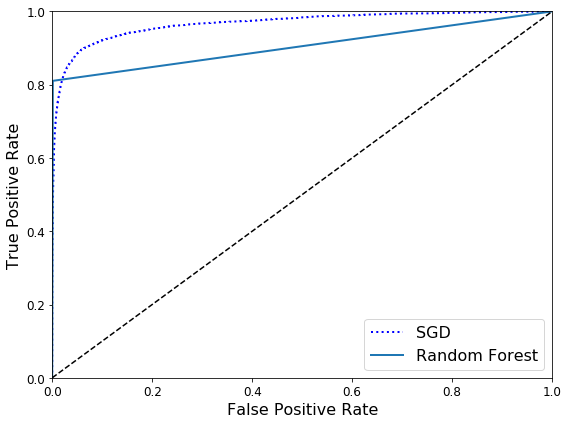

In [117]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [118]:
roc_auc_score(y_train_3, y_scores_forest)

0.9046202187077504

In [120]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)
precision_score(y_train_3, y_train_pred_forest)

0.9892494525184153

In [121]:
recall_score(y_train_3, y_train_pred_forest)

0.8104713749796119

In [ ]:
"""The predicting the class with probability 1 model shows similar results as the predicting probability of 
survival predict class"""

# Problem 7
Use Titanic data and model estimated in the problem 6. Show confusion matrix for each model. Describe the most typical error each model has. 

In [66]:
# The alhorithm relies on randomness and for reproducibility requires random_state parameter.
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(train_prepared, train_label)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [73]:
some_digit = train_prepared[1]

In [74]:
some_digit

array([ 0.66386103,  0.43279337,  0.78684529, -0.47367361])

In [75]:
sgd_clf.predict([some_digit])

array([1], dtype=int64)

In [83]:
y_train_3 = (y_train == train[3])

NameError: name 'y_train' is not defined

In [76]:
# Let's start with accuracy
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_prepared, train_label, cv=3, scoring="accuracy")

array([0.45117845, 0.68686869, 0.7037037 ])

In [77]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, train_prepared, train_label, cv=3)

In [78]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train_label, y_train_pred)

array([[396, 153],
       [191, 151]], dtype=int64)

In [79]:
y_train_perfect_predictions = train_label

In [80]:
# Example of perfect prediction. We made a table from two identical vectors. No errors!
confusion_matrix(train_label, y_train_perfect_predictions)

array([[549,   0],
       [  0, 342]], dtype=int64)

In [81]:
from sklearn.metrics import precision_score, recall_score
precision_score(train_label, y_train_pred) 

0.4967105263157895

In [82]:
recall_score(train_label, y_train_pred)

0.4415204678362573

In [84]:
# Get the secision scores
y_scores = cross_val_predict(sgd_clf, train_prepared, train_label, cv=3,
                             method="decision_function")

In [89]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(train_label, y_scores)

Saving figure precision_recall_vs_threshold_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\classification\\precision_recall_vs_threshold_plot.png'

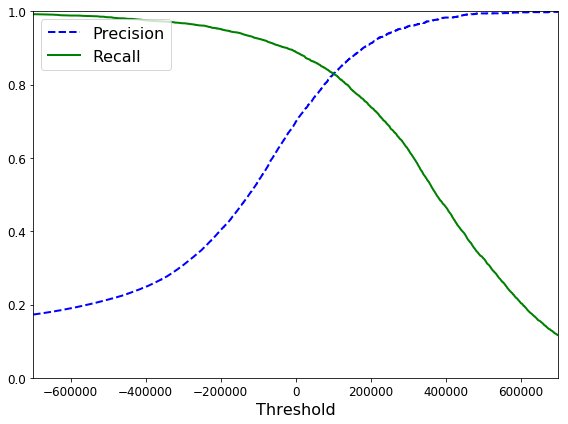

In [124]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [ ]:
"""False postive rates are similar for both models."""